In [1]:
import torch
import torch.nn as nn

In [2]:
!nvidia-smi

Mon Jun  5 22:55:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.56       Driver Version: 526.56       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8    12W /  N/A |     11MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import os

BASE_DIR = "D:Dataset/dataset/kitti/"
LABEL_PATH = os.path.join(BASE_DIR,'data_object_label_2/training/label_2')

IMAGE_PATH = os.path.join(BASE_DIR,'data_object_image_2/training/image_2')
IMAGE_STEREO_PATH = os.path.join(BASE_DIR,'data_object_image_3/training/image_3')

IMAGE_WIDTH = 256
IMAGE_HEIGHT = 160

In [11]:
images =  [(f) for f in os.listdir(IMAGE_PATH) if os.path.isfile(os.path.join(IMAGE_PATH, f))]
masks = [(f) for f in os.listdir(LABEL_PATH) if os.path.isfile(os.path.join(LABEL_PATH, f))]
masks.sort()

In [31]:
import pandas as pd
import cv2
df=pd.DataFrame(np.column_stack([masks]),columns=["masks"])
df["images"] = df["masks"].apply(lambda x: x[:-3]+"png")

img = cv2.imread(os.path.join(IMAGE_PATH, '000001.png'))

print(img.shape)
print(df.shape)
df.head()

(375, 1242, 3)
(7481, 2)


masks      images
0  000000.txt  000000.png
1  000001.txt  000001.png
2  000002.txt  000002.png
3  000003.txt  000003.png
4  000004.txt  000004.png

In [32]:
def get_labels(label_filename):
    """
        label 데이터 한개에 들어있는 객체 정보 
    
        #Values    Name      Description
        ----------------------------------------------------------------------------
           1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                             'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                             'Misc' or 'DontCare'
           1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                             truncated refers to the object leaving image boundaries
           1    occluded     Integer (0,1,2,3) indicating occlusion state:
                             0 = fully visible, 1 = partly occluded
                             2 = largely occluded, 3 = unknown
           1    alpha        Observation angle of object, ranging [-pi..pi]
           4    bbox         2D bounding box of object in the image (0-based index):
                             contains left, top, right, bottom pixel coordinates
           3    dimensions   3D object dimensions: height, width, length (in meters)
           3    location     3D object location x,y,z in camera coordinates (in meters)
           1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
           1    score        Only for results: Float, indicating confidence in
                             detection, needed for p/r curves, higher is better.
    """
    data =  pd.read_csv(os.path.join(LABEL_PATH,label_filename), sep=" ", 
                       names=['label', 'truncated', 'occluded', 'alpha', 
                              'bbox_xmin', 'bbox_ymin', 'bbox_xmax', 
                              'bbox_ymax', 'dim_height', 'dim_width', 'dim_length', 
                              'loc_x', 'loc_y', 'loc_z', 'rotation_y', 'score'])
    
    
    
    
    return data
    
get_labels('000001.txt')

label  truncated  occluded  alpha  bbox_xmin  bbox_ymin  bbox_xmax  \
0     Truck        0.0         0  -1.57     599.41     156.40     629.75   
1       Car        0.0         0   1.85     387.63     181.54     423.81   
2   Cyclist        0.0         3  -1.65     676.60     163.95     688.98   
3  DontCare       -1.0        -1 -10.00     503.89     169.71     590.61   
4  DontCare       -1.0        -1 -10.00     511.35     174.96     527.81   
5  DontCare       -1.0        -1 -10.00     532.37     176.35     542.68   
6  DontCare       -1.0        -1 -10.00     559.62     175.83     575.40   

   bbox_ymax  dim_height  dim_width  dim_length    loc_x    loc_y    loc_z  \
0     189.25        2.85       2.63       12.34     0.47     1.49    69.44   
1     203.12        1.67       1.87        3.69   -16.53     2.39    58.49   
2     193.93        1.86       0.60        2.02     4.59     1.32    45.84   
3     190.13       -1.00      -1.00       -1.00 -1000.00 -1000.00 -1000.00   
4     187.45       -1.00      -1.00       -1.00 -1000.00 -1000.00 -1000.00   
5     185.27       -1.00      -1.00       -1.00 -1000.00 -1000.00 -1000.00   
6     183.15       -1.00      -1.00       -1.00 -1000.00 -1000.00 -1000.00   

   rotation_y  score  
0       -1.56    NaN  
1        1.57    NaN  
2       -1.55    NaN  
3      -10.00    NaN  
4      -10.00    NaN  
5      -10.00    NaN  
6      -10.00    NaN

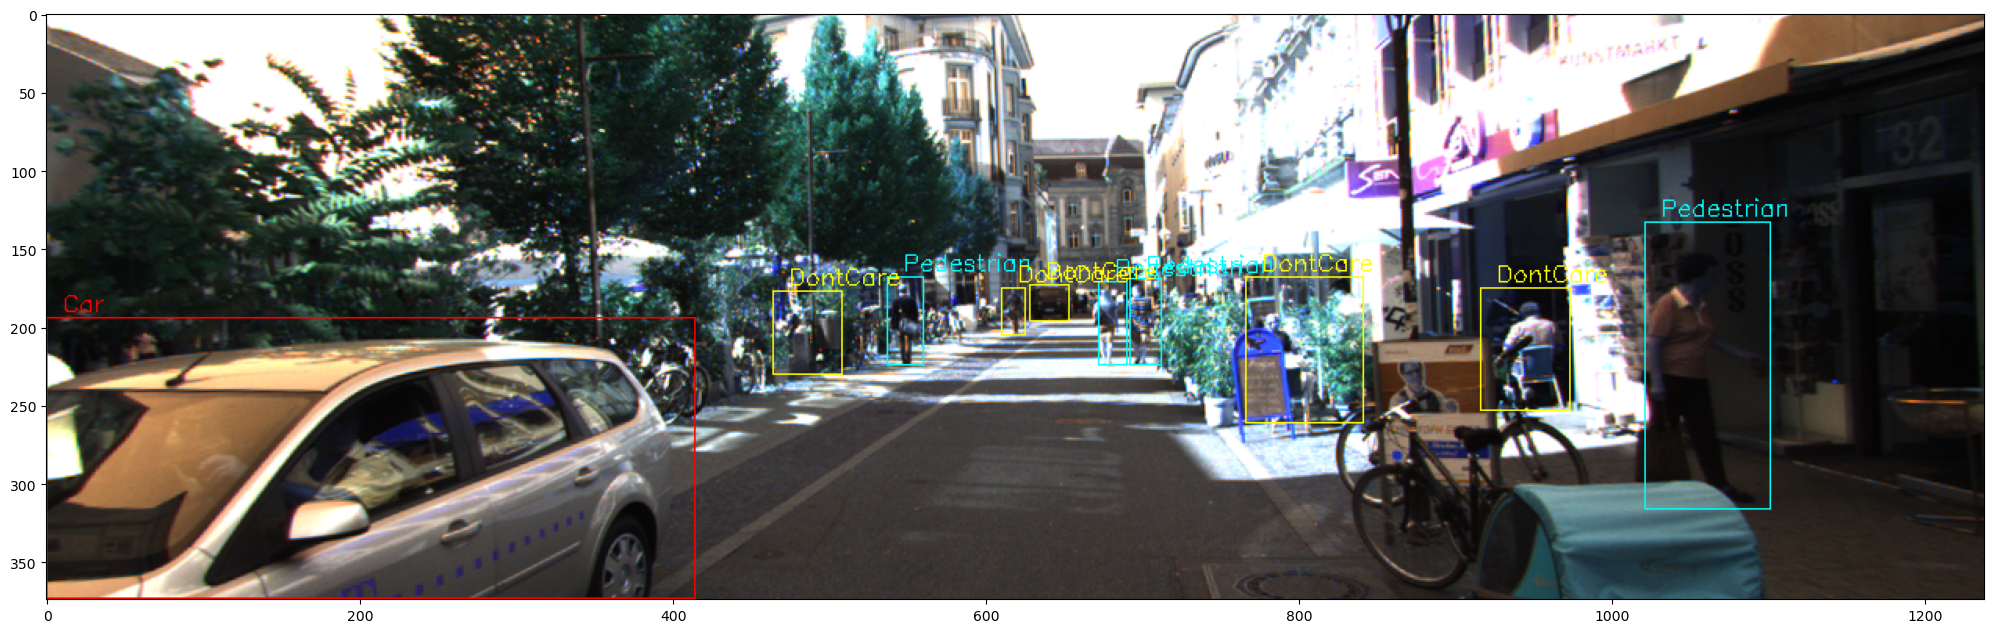

In [38]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (25, 14)

LABEL_COLORS = {
    'Car': (255, 0, 0),
    'Van': (255, 255, 0),
    'Truck': (255, 255, 255),
    'Pedestrian': (0, 255, 255),
    'Person_sitting': (0, 255, 255),
    'Cyclist': (0, 128, 255),
    'Tram': (128, 0, 0),
    'Misc': (0, 255, 255),
    'DontCare': (255, 255, 0)
}


def open_image(image_filename):
    return cv2.imread(os.path.join(IMAGE_PATH, image_filename))


def draw_box2d(image, labels, ax=None):
    """
    이미지에 객체 bbox 그리기
    """
    img = image.copy()
    for index, row in labels.iterrows():
        left_corner = (int(row.bbox_xmin), int(row.bbox_ymin))  # 좌상단
        right_corner = (int(row.bbox_xmax), int(row.bbox_ymax))  # 우하단
        label_color = LABEL_COLORS.get(row.label, (0, 255, 0))

        img = cv2.rectangle(img, left_corner, right_corner, label_color, 1)
        img = cv2.putText(img, str(row.label),
                          (left_corner[0] + 10, left_corner[1] - 4), # 좌상단 x+10, y-4
                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, label_color, 1)
    if ax == None:
        plt.imshow(img)
    else:
        ax.imshow(img)


def draw_box2d_id(id):
    """
        id -> draw_box(id)
    """
    return draw_box2d(open_image(id + '.png'), get_labels(id + '.txt'))


draw_box2d_id('000015')

In [39]:
DTYPE = np.float64

def get_image(path):
    return cv2.imread(path)

def create_mask(mask_dir, img_shape):
    """
    Unet 기반이기 떄문에 mask를 제작
    """
    mask = np.zeros(shape=(img_shape[0], img_shape[1], 1), dtype = DTYPE)
    

    with open(mask_dir) as f:
        content = f.readlines()
    content = [x.split() for x in content] # 객체 1개 검출 데이터
    for item in content:
        # ?왜 다른 객체는 적용x?
        if item[0]=='Car' or item[0]=='Truck' or item[0]=='Van' or item[0]=='Pedestrian':
            ul_col, ul_row = int(float(item[4])), int(float(item[5])) # 좌상단 점
            lr_col, lr_row = int(float(item[6])), int(float(item[7])) # 우하단 점
            
            mask[ul_row:lr_row, ul_col:lr_col, 0] = 1 # 해당 bbox넓이의 mask를 1, 나머지는 0
    return mask


def draw_mask(image, mask, ax = None):
    rgb_mask = np.repeat(mask, 3, axis = 2)
    img = cv2.addWeighted( image, 0.5, rgb_mask, 0.5, 0)
    if ax == None:
        plt.imshow(img)
    else:
        ax.imshow(img)
        
def draw_mask_id(id):
    # ponieważ maska to wartości 0,1 a obraz to wartości 0-255, to obraz trzeba podzielić przez 255.0
    img = np.array(get_image(os.path.join(IMAGE_PATH,id + '.png')) / 255.0, dtype = DTYPE) 
    mask = create_mask(os.path.join(LABEL_PATH,  id + '.txt'), img.shape )
    draw_mask(img,mask)
    plt.show()
    
    
draw_mask_id('000004')

In [44]:
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

tfs = transforms.Compose([
    iaa.Sequential([
        iaa.flip.Fliplr(p=0.5),
        iaa.flip.Flipud(p=0.5),
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.MultiplyBrightness(mul=(0.65, 1.35)),
    ]).augment_image,
    transforms.ToTensor()
])


train_transform = A.Compose([
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


class KittiDataset(Dataset):

    def __init__(self,
                 df,
                 shape=(IMAGE_WIDTH, IMAGE_HEIGHT),
                 label_path=LABEL_PATH,
                 image_path=IMAGE_PATH,
                 augmentation=None):
        super(KittiDataset, self).__init__()
        self.df = df
        self.shape = shape

        self.label_path = label_path
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def get_x(self, index):
        return get_image(
            os.path.join(self.image_path, self.df.loc[index][self.image_col]))

    def get_y(self, index, shape):
        return create_mask(
            os.path.join(self.label_path, self.df.loc[index][self.mask_col]),
            shape)

    def __getitem__(self, idx):

        # image full path
        image_r = self.get_x(i)
        # create mask(label path)
        mask_r = self.get_y(i, image_r.shape)

        # resize
        image_r = cv2.resize(image_r, (self.shape[0], self.shape[1]))
        mask_r = cv2.resize(mask_r, (self.shape[0], self.shape[1]))
        
        # Augemtation
        if self.augmentation is not None:
            mask_r = np.array(mask_r, dtype=np.int32)
            segmap = SegmentationMapsOnImage(mask_r, shape=image_r.shape)
            image_r, segmap = self.augmentation(image = image_r, segmentation_maps = segmap)
            mask_r = segmap.get_arr().astype(np.float64)
            
        # ToTensor()
        image_r = ToTensorV2()(image_r)
        mask_r = ToTen
        
        return image, label